In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, DataFrames

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184


# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 10.
z_grid = unique([range(0., 0.1, length = 400)' range(0.1, 1., length = 400)' range(1., z_max, length = 100)'])
M = length(z_grid)

# Define common objects. 
d_0 = 3.0700
d_T = 2.5019
params = (ρ = 0.02, σ = 3.9896, N = 10, θ = 4.7060, γ = 1.00, κ = 0.0103, ζ = 1, η = 0, Theta = 1, χ = 0.4631, υ = 0.0775, μ = 0, δ = 0.053) # Baselines per Jesse.
δ = params.δ
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T


stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

(z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  9.18182, 9.27273, 9.36364, 9.45455, 9.54545, 9.63636, 9.72727, 9.81818, 9.90909, 10.0], tstops = nothing, Δ_E = 1.0e-6)

## Welfare in steady states

In [4]:
# auxil. function that extracts and displays welfare information from steady state solutions
function display_stationary_sol(stationary_sol)
    @unpack g, z_hat, Ω, π_bar_agg, y, c, λ_ii, U_bar, L_tilde, z_bar, w, x, π_min, r, a, b, S = stationary_sol
    summary_df1 = DataFrame(g = g, z_hat = z_hat, Ω = Ω, π_bar_agg = π_bar_agg, 
                            y = y, c = c, λ_ii = λ_ii)
    summary_df2 = DataFrame(U_bar_0 = U_bar(0.0),
                            L_tilde = L_tilde, z_bar = z_bar, w = w, x = x, π_min = π_min)
    summary_df3 = DataFrame(r = r, a = a, b = b, S = S)
    println(summary_df1)
    println(summary_df2)    
    println(summary_df3)
end;

### Steady state at `T`

In [5]:
display_stationary_sol(stationary_sol)

1×7 DataFrame
│ Row │ g         │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64   │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼───────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.0201157 │ 1.41723 │ 1.29944 │ 0.241359  │ 1.32785 │ 1.32785 │ 0.758212 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w       │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼─────────┼─────────┼───────────┤
│ 1   │ 64.4675 │ 0.208646 │ 1.67795 │ 0.42058 │ 1.0     │ 0.0563327 │
1×4 DataFrame
│ Row │ r         │ a       │ b       │ S         │
│     │ Float64   │ Float64 │ Float64 │ Float64   │
├─────┼───────────┼─────────┼─────────┼───────────┤
│ 1   │ 0.0931157 │ 9.4076  │ 0.14236 │ 0.0281562 │


### Steady state at `0`

In [6]:
display_stationary_sol(stationary_sol_0)

1×7 DataFrame
│ Row │ g         │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64   │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼───────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.0104317 │ 1.83737 │ 1.86064 │ 0.26096   │ 1.4463  │ 1.4463  │ 0.900275 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w        │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64  │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼──────────┼─────────┼───────────┤
│ 1   │ 44.5296 │ 0.190386 │ 1.78641 │ 0.447766 │ 1.0     │ 0.0477907 │
1×4 DataFrame
│ Row │ r         │ a       │ b       │ S          │
│     │ Float64   │ Float64 │ Float64 │ Float64    │
├─────┼───────────┼─────────┼─────────┼────────────┤
│ 1   │ 0.0834317 │ 12.929  │ 0.10122 │ -0.0174171 │


# Transition dynamics

Define the objective function:

In [7]:
function solve_with_candidate(candidate; detailed_solution = true)
    T = candidate[end]
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero

    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = CubicSplineInterpolation(ts, E_hat_vec_scaled) # might worth trying cubic spline
    E_hat(t) = E_hat_interpolation(t)

    M = log(Ω_T/Ω_0) / quadgk(E_hat, 0, T)[1]
    Ω_derivative(Ω,p,t) = M*E_hat(t)*Ω
    Ω_solution = DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15)
    Ω(t) = t <= T ? Ω_solution(t) : Ω_solution(T)
    E(t) = M*E_hat(t) + δ
    
    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    return solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
end

function residuals_given_solution(solved, ENTRY_RESIDUALS_NODES_COUNT)
  # interpolate on returned entry_residual
  entry_residual_interpolated = LinearInterpolation(solved.t, solved.entry_residual)

  # evaluate entry_residual on entry_residual_nodes, return the norm
  entry_residuals_nodes = range(0, stop = solved.t[end], length = ENTRY_RESIDUALS_NODES_COUNT + 2)
  
  # returns the vector of residuals
  return entry_residual_interpolated.(entry_residuals_nodes[2:(end-1)])
end

function evaluate_candidate_with_ssr(candidate)
#   candidate = [candidate...] # if candidate is a tuple, convert it to an array
  # solve the dynamics; if solution is not valid, return Inf
  solved = try solve_with_candidate(candidate, ).results catch; return Inf end
  # get the resulting entry_residual vector
  residuals = residuals_given_solution(solved, ENTRY_RESIDUALS_NODES_COUNT)
  return (sqrt(sum(residuals .* WEIGHTS .* residuals)))
end

evaluate_candidate_with_ssr (generic function with 1 method)

Setup for optimizer:

In [8]:
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
SOLUTION = [-1.06452, -0.695666, -0.578766, -0.456422, -0.344281, -0.300501, -0.202732, -0.186203, -0.126591, -0.0865358, -0.0806862, -0.07445, -0.0706962, -0.0548628, 35.4599]
RANGES_NODES = map(i->(SOLUTION[i] - 5e-2, min(-1e-3, SOLUTION[i] + 5e-2)), 1:(E_NODE_COUNT-1))
RANGES = [RANGES_NODES; (33.999, 36.001)]
WEIGHTS = [fill(15, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-3)]
ITERATIONS = 1
SORT_CANDIDATE = true # this will make finding solution much more efficient when we use global optimization schemes

settings_optim = (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0,
                E_node_count = E_NODE_COUNT, entry_residuals_nodes_count = ENTRY_RESIDUALS_NODES_COUNT, 
                weights = WEIGHTS, ranges = RANGES, iterations = ITERATIONS,
                sort_candidate = SORT_CANDIDATE)
settings = merge(settings, settings_optim);

Find the corresponding solution:

In [9]:
solved = solve_full_model_global(SOLUTION, settings);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.20 secs, 2 evals, 1 steps, fitness=0.015741057

Optimization stopped after 2 steps and 2.3429999351501465 seconds
Termination reason: Max number of steps (1) reached
Steps per second = 0.8536065110355344
Function evals per second = 1.7072130220710688
Improvements/step = 1.0
Total function evaluations = 4


Best candidate found: [-1.11422, -0.665655, -0.579572, -0.441466, -0.386548, -0.349163, -0.233133, -0.140343, -0.143313, -0.0477129, -0.0963014, -0.11059, -0.0659066, -0.0945956, 34.5479]

Fitness: 0.011642534



In [10]:
v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results;

## Plots for Ω and `entry_residuals`

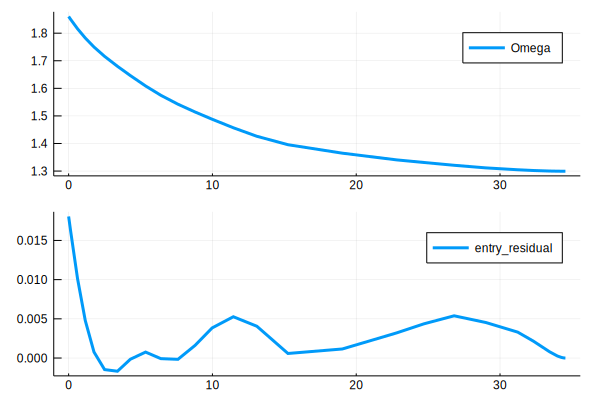

In [11]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

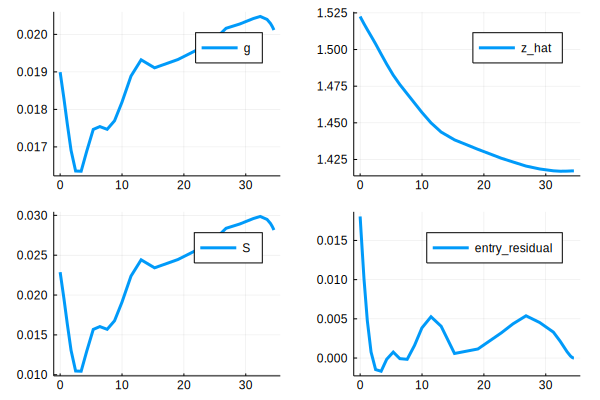

In [12]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

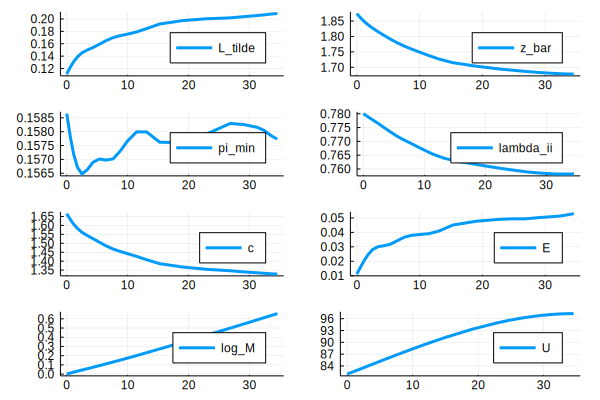

In [13]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

# Welfare analysis

### `log_M(t)`

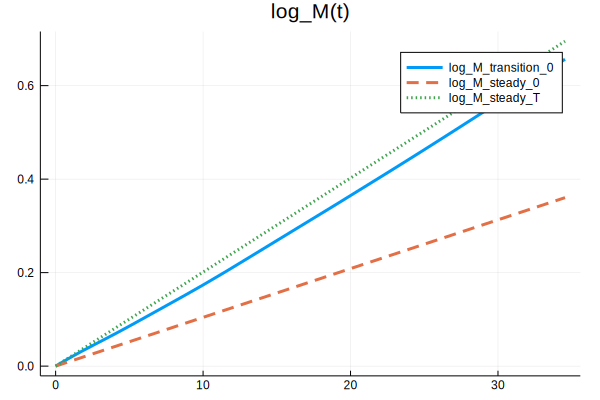

In [14]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

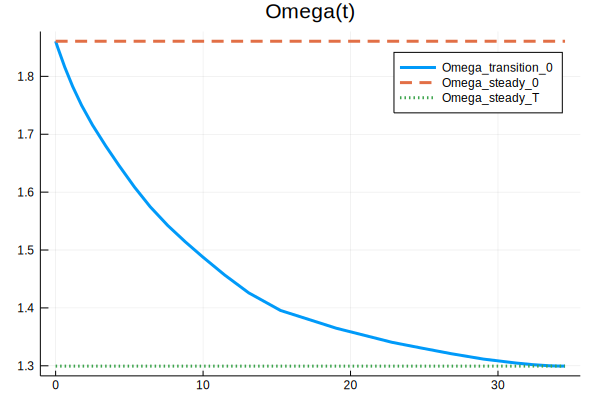

In [15]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

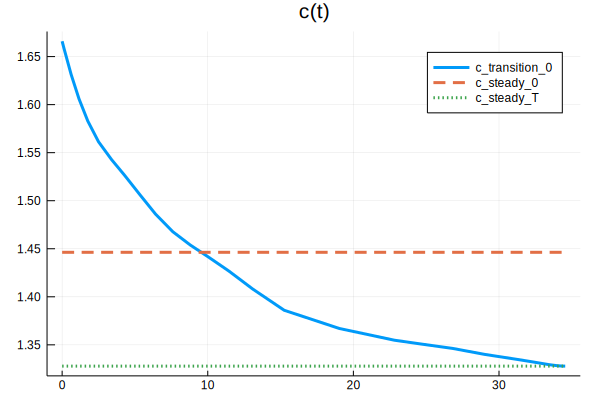

In [16]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

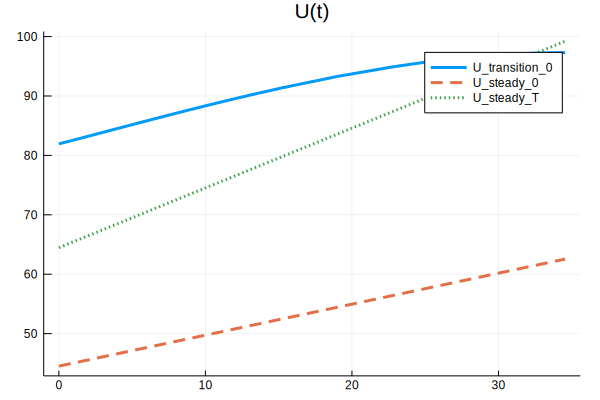

In [17]:
# # define c function (constant)
# ρ = params.ρ
# T = solved.t[end]
# U_steady_0(t) = (ρ*(log(stationary_sol_0.c + stationary_sol_0.g * t)) + stationary_sol_0.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) + stationary_sol.g * t) + stationary_sol.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) * stationary_sol.g*t) + stationary_sol.g) / (ρ^2)
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [18]:
 T = solved.t[end]
M_0 = exp(params.ρ*(stationary_sol.U_bar(T) - stationary_sol_0.U_bar(T)))

2.0819851844986603

### `M(0)` by autarky and transition from `t=0`

In [19]:
T = solved.t[end]
M_0 = exp(params.ρ*(solved.U[1] - stationary_sol_0.U_bar(T)))

1.473888447396325